# Human Activity Recognizer

## Outline

1. Visualize the Data with its Labels

2. Preprocess the Dataset

3. Split the Data into Train and Test Set

4. Implement the ConvLSTM Approach

    - 4.1. Construct the Model
    
    - 4.2. Compile & Train the Model
    
    - 4.3. Plot Model’s Loss & Accuracy Curves

5. implement the LRCN Approach
 
    - 5.1:` Construct the Model
    
    - 5.2.Compile & Train the Model
    
    - 5.3. Plot Model’s Loss & Accuracy Curves
    
6.Test the Best Performing Model on YouTube videos


## Import the Libraries

We will start by installing and importing the required libraries.

In [1]:
# Import the required libraries.
import os
import cv2
# import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

# from moviepy.editor import VideoFileClip
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from pytube import YouTube

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## 1. Visualize the Data with its Labels

In the first step, we will visualize the data along with labels to get an idea about what we will be dealing with. We will be using the [UCF50 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF50.php), consisting of realistic videos taken from youtube which differentiates this data set from most of the other available action recognition data sets as they are not realistic and are staged by actors. The Dataset contains:

*   **`50`** Action Categories

*   **`25`** Groups of Videos per Action Category

*   **`133`** Average Videos per Action Category

*   **`199`** Average Number of Frames per Video

*   **`320`** Average Frames Width per Video

*   **`240`** Average Frames Height per Video

*   **`26`** Average Frames Per Seconds per Video

For visualization, we will pick `20` random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written. This way we’ll be able to visualize a subset ( `20` random videos ) of the dataset.

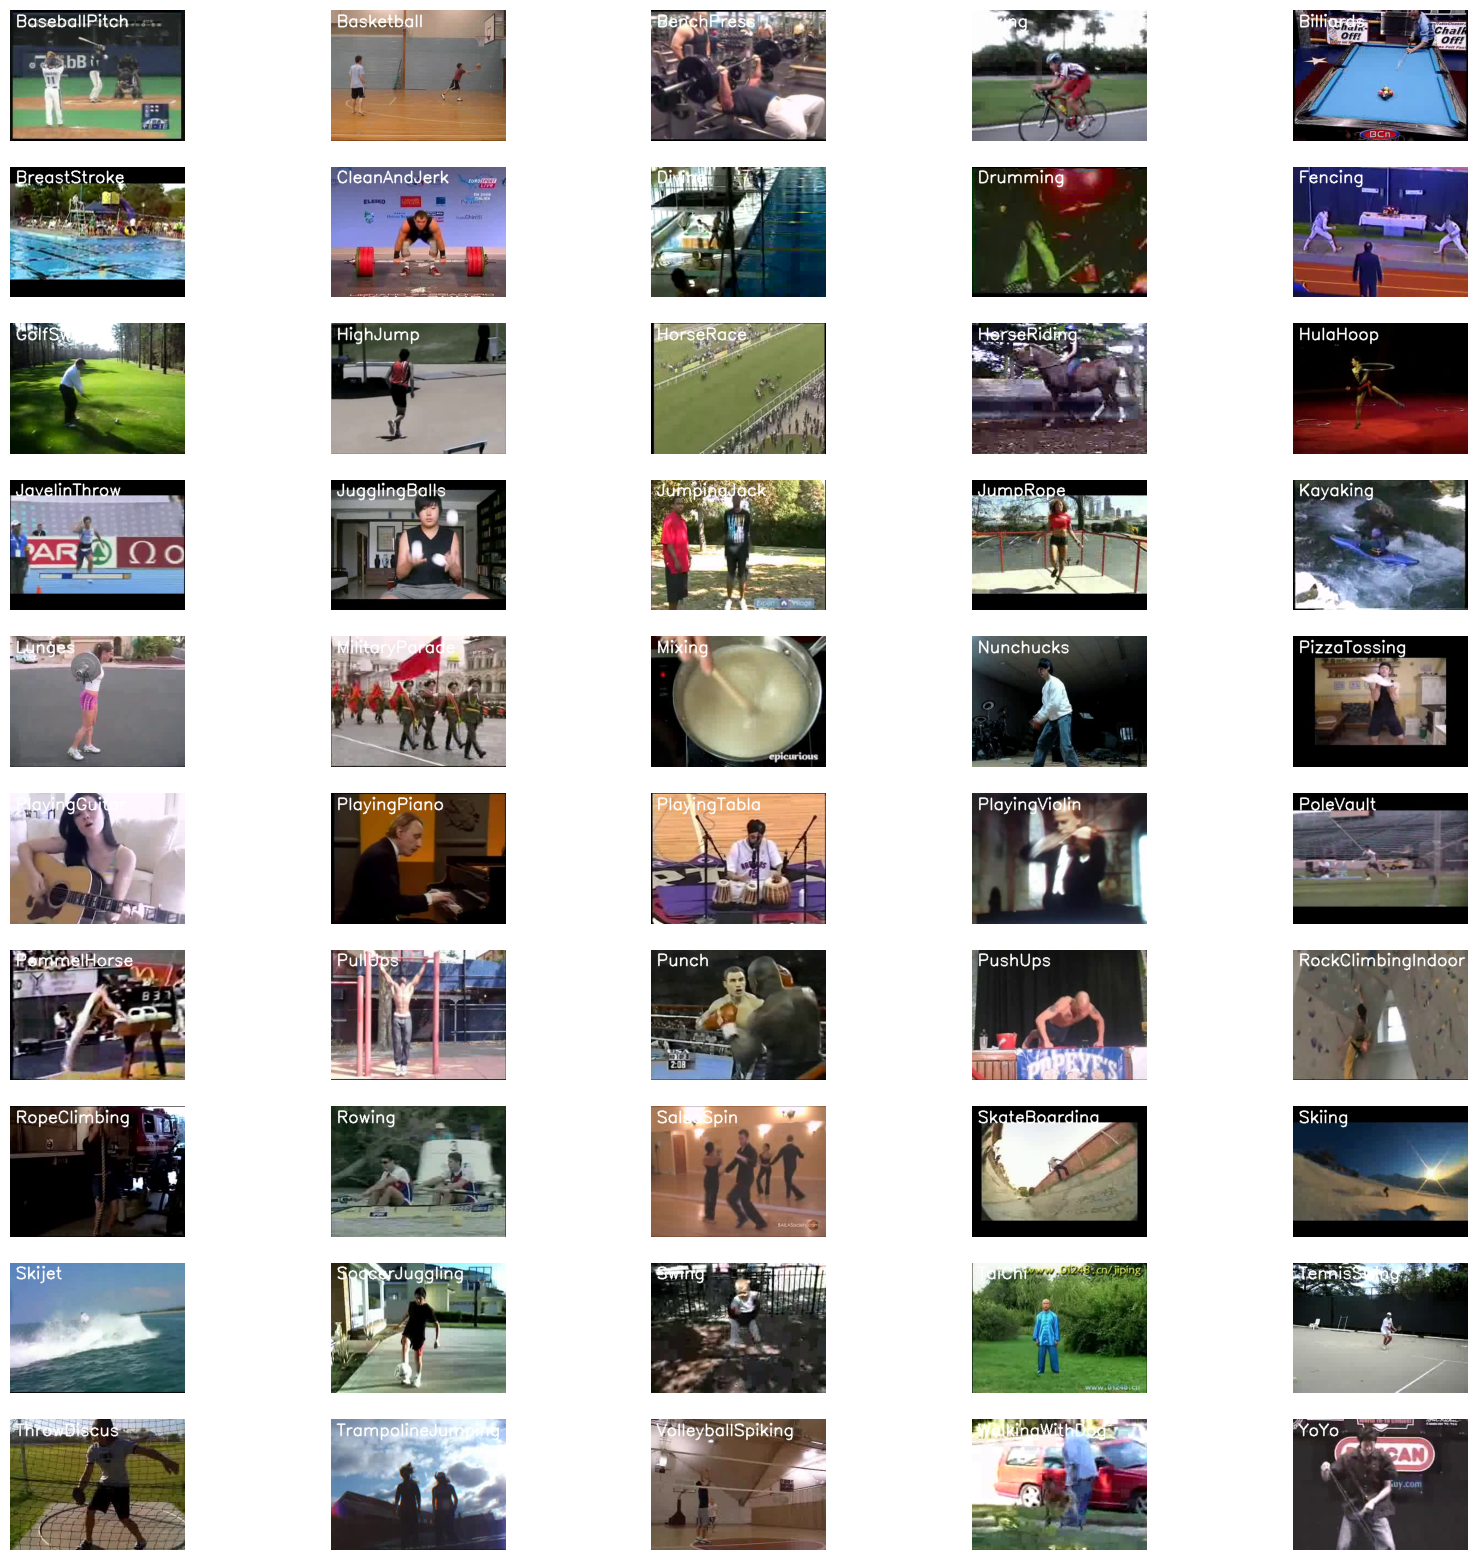

In [3]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

DATASET_DIR = "../data/UCF50"

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir(DATASET_DIR)

# Generate a visual representation of all class actions 
for index in range(len(all_classes_names)):

    # Retrieve a Class Name using the Index.
    selected_class_Name = all_classes_names[index]

    # Retrieve the list of all the video files present in the selected Class Directory.
    video_files_names_list = os.listdir(f'{DATASET_DIR}/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{DATASET_DIR}/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(10, 5, index + 1)
    plt.imshow(rgb_frame)
    plt.axis('off')
plt.show()

## 2. Preprocess the Dataset

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.


In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 

DATASET_DIR = "../data/UCF50"


In [ ]:
# sample tasks to perform on the dataset
def get_classes(directory, n_classes=None, seed=42):
    classes = os.listdir(directory)
    classes.sort()
    random.seed(seed)
    random.shuffle(classes)
    selected_classes = classes[:n_classes] if n_classes is not None and n_classes <= len(classes) else classes
    return selected_classes

# # Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
# CLASSES_LIST = get_classes(DATASET_DIR, n_classes=4, seed=42)

CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

### Create a Function to Extract, Resize & Normalize Frames

We will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames. 

In [5]:
def frames_extraction(video_path, sequence_length=20, image_height=64, image_width=64):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/sequence_length), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(sequence_length):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:

def frames_extraction(video_path, sequence_length=20, image_height=64, image_width=64):
    """
    Efficiently extract evenly spaced frames from a video, resize and normalize them.
    
    Args:
        video_path: Path to the video file.
        sequence_length: Number of frames to extract.
        image_height: Height to resize frames.
        image_width: Width to resize frames.
        
    Returns:
        frames_array: NumPy array of shape (sequence_length, image_height, image_width, 3)
                      with values normalized between 0 and 1.
    """

    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video {video_path}")

    # Total frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        cap.release()
        return np.zeros((sequence_length, image_height, image_width, 3), dtype=np.float32)

    # Compute indices of frames to extract (evenly spaced)
    frame_indices = np.linspace(0, total_frames - 1, sequence_length, dtype=int)

    # Preallocate array
    frames_array = np.zeros((sequence_length, image_height, image_width, 3), dtype=np.float32)

    current_frame = 0
    next_index = 0

    while next_index < sequence_length:
        ret, frame = cap.read()
        if not ret:
            break

        if current_frame == frame_indices[next_index]:
            # Resize and normalize
            resized = cv2.resize(frame, (image_width, image_height))  # correct order
            frames_array[next_index] = resized.astype(np.float32) / 255.0
            next_index += 1

        current_frame += 1

    # If video too short, repeat last frame
    while next_index < sequence_length:
        frames_array[next_index] = frames_array[next_index - 1]
        next_index += 1

    cap.release()
    return frames_array


### Create a Function for Dataset Creation

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [6]:
def create_dataset(classes_list: list, num_files = None, sequence_length: int = 20, seed: int = 42):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        
        # Display the name of the class whose data is being extracted.
        print(f'Folder {class_index + 1}/{len(classes_list)}...Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        np.random.seed(seed=seed)
        if num_files:
            files_list = np.random.permutation(files_list)[:num_files]
        else:
            files_list = np.random.permutation(files_list)
            
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == sequence_length:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [7]:
# Create the dataset.
features, labels, video_files_paths = create_dataset(classes_list=CLASSES_LIST,)

Folder 1/4...Extracting Data of Class: WalkingWithDog
Folder 2/4...Extracting Data of Class: TaiChi
Folder 3/4...Extracting Data of Class: Swing
Folder 4/4...Extracting Data of Class: HorseRace


In [8]:
features.shape, labels.shape

((487, 20, 64, 64, 3), (487,))

In [ ]:
# # SAVE DATA TO DISK TO AVOID EXTRACTION EVERYTIME THIS RUNS
# EXTRACTED = "../data/extracted/"

# os.makedirs(EXTRACTED, exist_ok=True)
# # Save
# np.save(f"{EXTRACTED}/features.npy", features.astype(np.float32))
# np.save(f"{EXTRACTED}/labels.npy", labels.astype(np.int32))

# # Load
# X = np.load(f"{EXTRACTED}/features.npy", mmap_mode="r")
# y = np.load(f"{EXTRACTED}/labels.npy", mmap_mode="r")

## 3. Split the Data into Train and Test Set

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [9]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            stratify=labels, random_state = seed_constant)

## 4. Implement the ConvLSTM Approach

In this step, we will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation. 

For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input `(width, height, num_of_channels)` whereas a simple LSTM only takes in 1-dimensional input hence an LSTM is incompatible for modeling Spatio-temporal data on its own.

You can read the paper [**Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting**](https://arxiv.org/abs/1506.04214v1) by **Xingjian Shi** (NIPS 2015), to learn more about this architecture.


### 4.1: Construct the Model


To construct the model, we will use Keras [**`ConvLSTM2D`**](https://keras.io/api/layers/recurrent_layers/conv_lstm2d) recurrent layers. The **`ConvLSTM2D`** layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers is flattened in the end and is fed to the **`Dense`** layer with softmax activation which outputs the probability of each action category. 

We will also use **`MaxPooling3D`** layers to reduce the dimensions of the frames and avoid unnecessary computations and **`Dropout`** layers to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) the model on the data. The architecture is a simple one and has a small number of trainable parameters. This is because we are only dealing with a small subset of the dataset which does not require a large-scale model.

In [ ]:
def create_convlstm_model(input_shape, output_classes, activation="relu"):
    '''
    This function will construct the required convlstm model.
    NOTE: The use of 1 in the first dimension of pool size, so as not to reduce the sequence length.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = keras.Sequential()
    
    model.add(layers.Input(shape=input_shape))
    model.add(layers.ConvLSTM2D(filters = 32, kernel_size = (3, 3), activation = activation, data_format = "channels_last",
                        return_sequences=True))
    
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    
    model.add(layers.ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = activation, data_format = "channels_last",
                        return_sequences=True))
    
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    
    model.add(layers.ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = activation, data_format = "channels_last",
                        return_sequences=True))
    
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    
    model.add(layers.ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = activation, data_format = "channels_last",
                        return_sequences=True))
    
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(layers.Flatten()) 
    
    model.add(layers.Dense(output_classes, activation = "softmax"))
     
    # Display the models summary.
    model.summary()
    
    return model

Now we will utilize the function **`create_convlstm_model()`** created above, to construct the required `convlstm` model.

In [11]:
# Construct the required convlstm model.
input_shape = features_train.shape[1:]
output_classes = len(CLASSES_LIST)
convlstm_model = create_convlstm_model(input_shape=input_shape, output_classes=output_classes, activation="relu")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 32) │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 16) │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 8)  │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 7, 7, 8)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        11,524 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,516 (392.64 KB)

 Trainable params: 100,516 (392.64 KB)

 Non-trainable params: 0 (0.00 B)

#### Check Model’s Structure


Now we will use the **`plot_model()`** function, to check the structure of the constructed model, this is helpful while constructing a complex network and making that the network is created correctly.

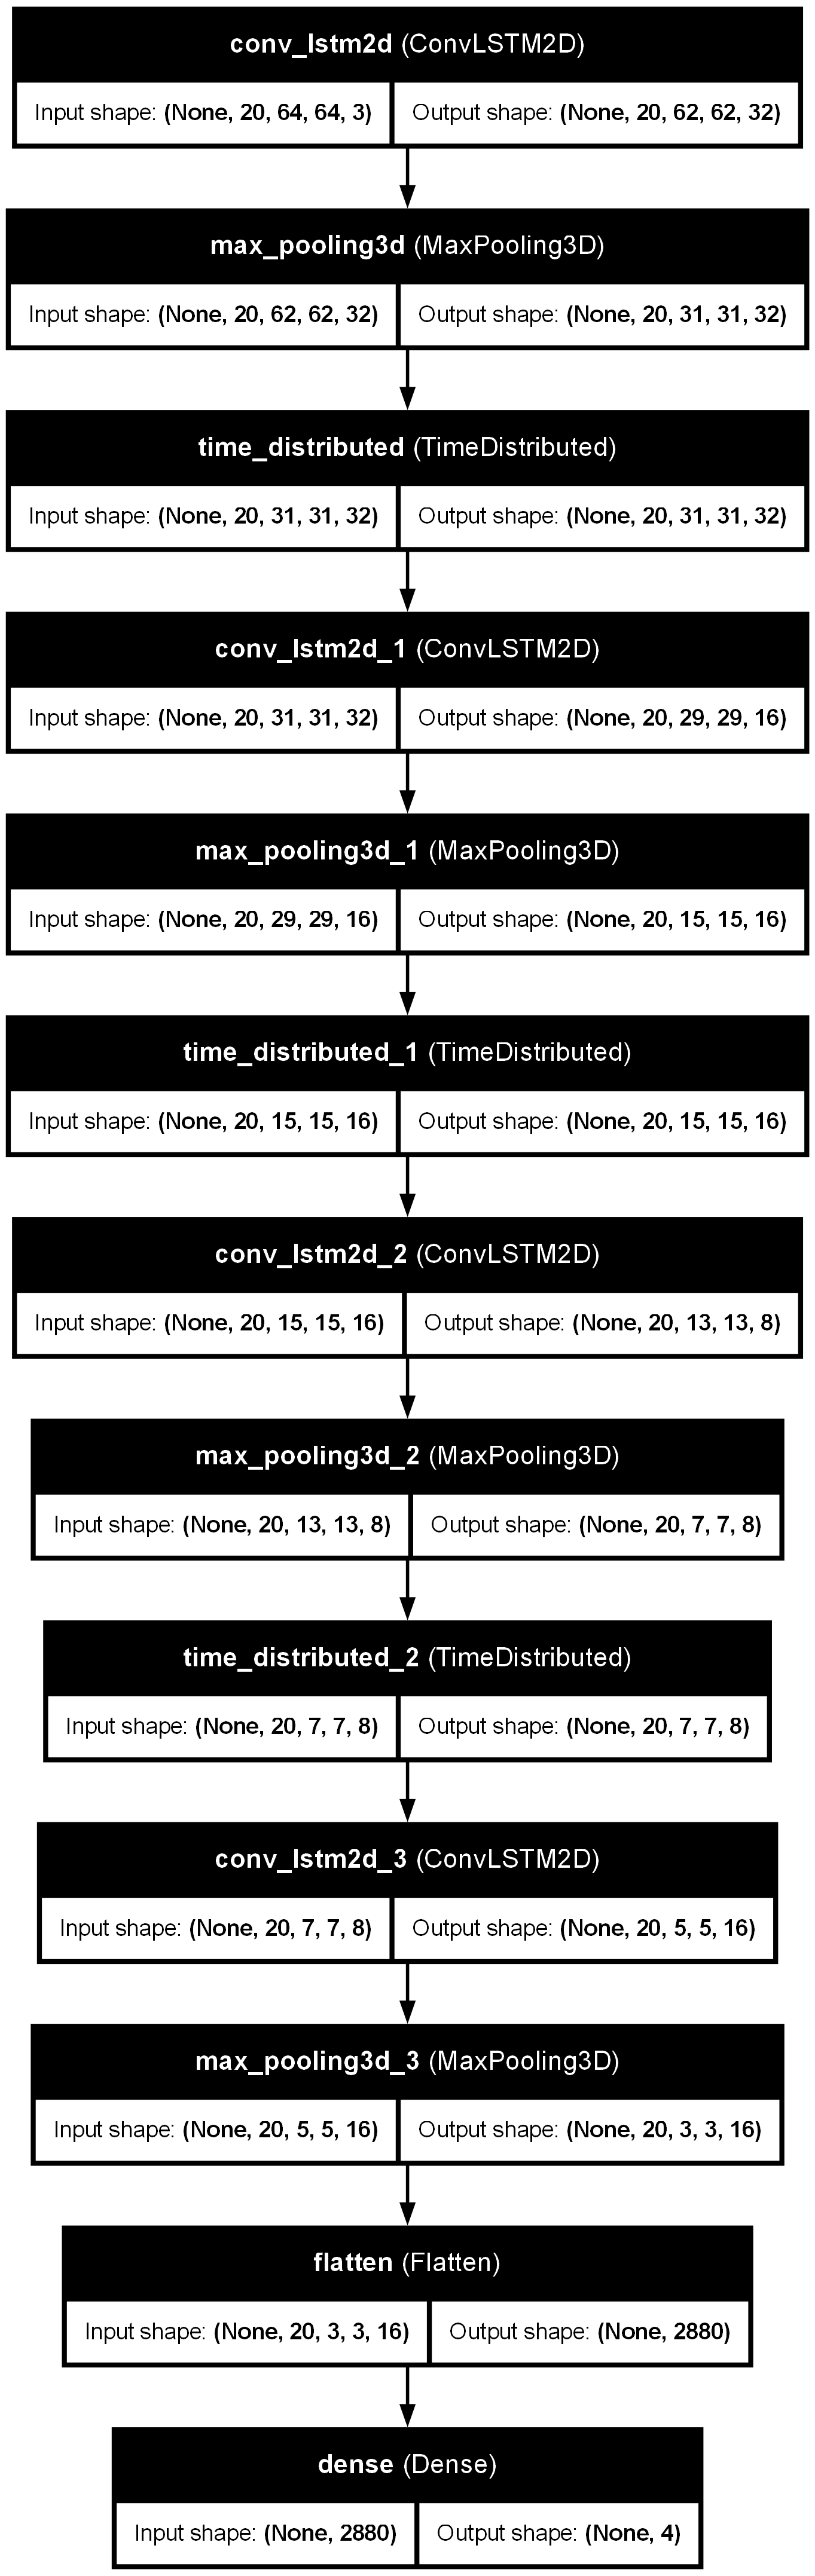

In [12]:
# Plot the structure of the contructed model.
keras.utils.plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### 4.2. Compile & Train the Model

Next, we will add an early stopping callback to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) and start the training after compiling the model.

In [13]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = "adam",
    metrics = ["accuracy"]
    )

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train,
                                                     epochs = 50, batch_size = 4, verbose=2,
                                                     shuffle = True, validation_split = 0.1,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
88/88 - 67s - 756ms/step - accuracy: 0.2457 - loss: 1.3887 - val_accuracy: 0.3077 - val_loss: 1.3794
Epoch 2/50
88/88 - 53s - 601ms/step - accuracy: 0.3086 - loss: 328.0936 - val_accuracy: 0.4103 - val_loss: 206.3983
Epoch 3/50
88/88 - 55s - 623ms/step - accuracy: 0.3114 - loss: 3.0245 - val_accuracy: 0.3590 - val_loss: 2.4449
Epoch 4/50
88/88 - 52s - 590ms/step - accuracy: 0.3286 - loss: 1.7098 - val_accuracy: 0.3846 - val_loss: 1.8079
Epoch 5/50
88/88 - 52s - 592ms/step - accuracy: 0.3514 - loss: 1.6554 - val_accuracy: 0.3846 - val_loss: 2.7175
Epoch 6/50
88/88 - 52s - 590ms/step - accuracy: 0.3657 - loss: 1.8000 - val_accuracy: 0.3846 - val_loss: 3.2888
Epoch 7/50
88/88 - 53s - 597ms/step - accuracy: 0.3571 - loss: 1.6410 - val_accuracy: 0.4103 - val_loss: 2.8841
Epoch 8/50
88/88 - 52s - 591ms/step - accuracy: 0.3657 - loss: 1.4421 - val_accuracy: 0.4103 - val_loss: 2.5199
Epoch 9/50
88/88 - 52s - 591ms/step - accuracy: 0.3971 - loss: 1.4525 - val_accuracy: 0.3846 - val_l

#### Evaluate the Trained Model

After training, we will evaluate the model on the test set.

In [14]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 991ms/step - accuracy: 0.6984 - loss: 1.0043


### 4.3. Plot Model’s Loss & Accuracy Curves

Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [15]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()
    plt.show()


Now we will utilize the function **`plot_metric()`** created above, to visualize and understand the metrics.

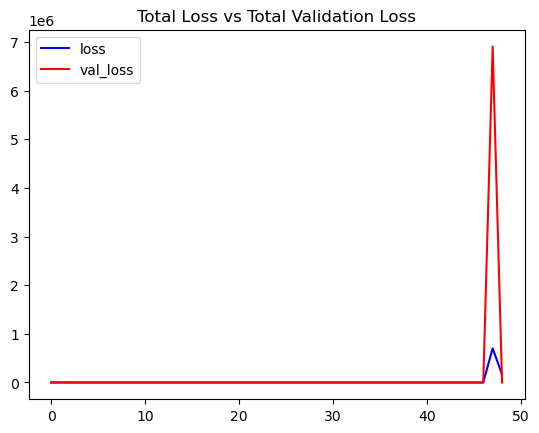

In [16]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Training Loss vs Validation Loss')

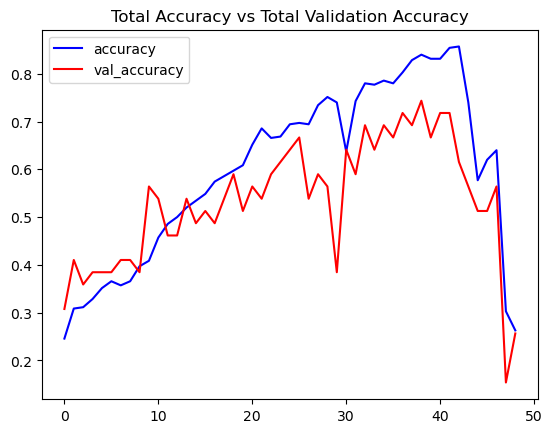

In [17]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Training Accuracy vs Validation Accuracy') 

## 5. Implement the LRCN Approach

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video. 


But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

You can read the paper [Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/abs/1411.4389?source=post_page---------------------------) by Jeff Donahue (CVPR 2015), to learn more about this architecture.

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot. 


### 5.1. Construct the Model

To implement our LRCN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [18]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = keras.Sequential()
    
    model.add(layers.TimeDistributed(layers.Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(layers.TimeDistributed(layers.MaxPooling2D((4, 4)))) 
    model.add(layers.TimeDistributed(layers.Dropout(0.25)))
    
    model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((4, 4))))
    model.add(layers.TimeDistributed(layers.Dropout(0.25)))
    
    model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Dropout(0.25)))
    
    model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(layers.TimeDistributed(layers.Flatten()))
                                      
    model.add(layers.LSTM(32))
                                      
    model.add(layers.Dense(len(CLASSES_LIST), activation = 'softmax'))

    # Display the models summary.
    model.summary()
    
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [19]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()


d:\Users\shams\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

#### Check Model’s Structure

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

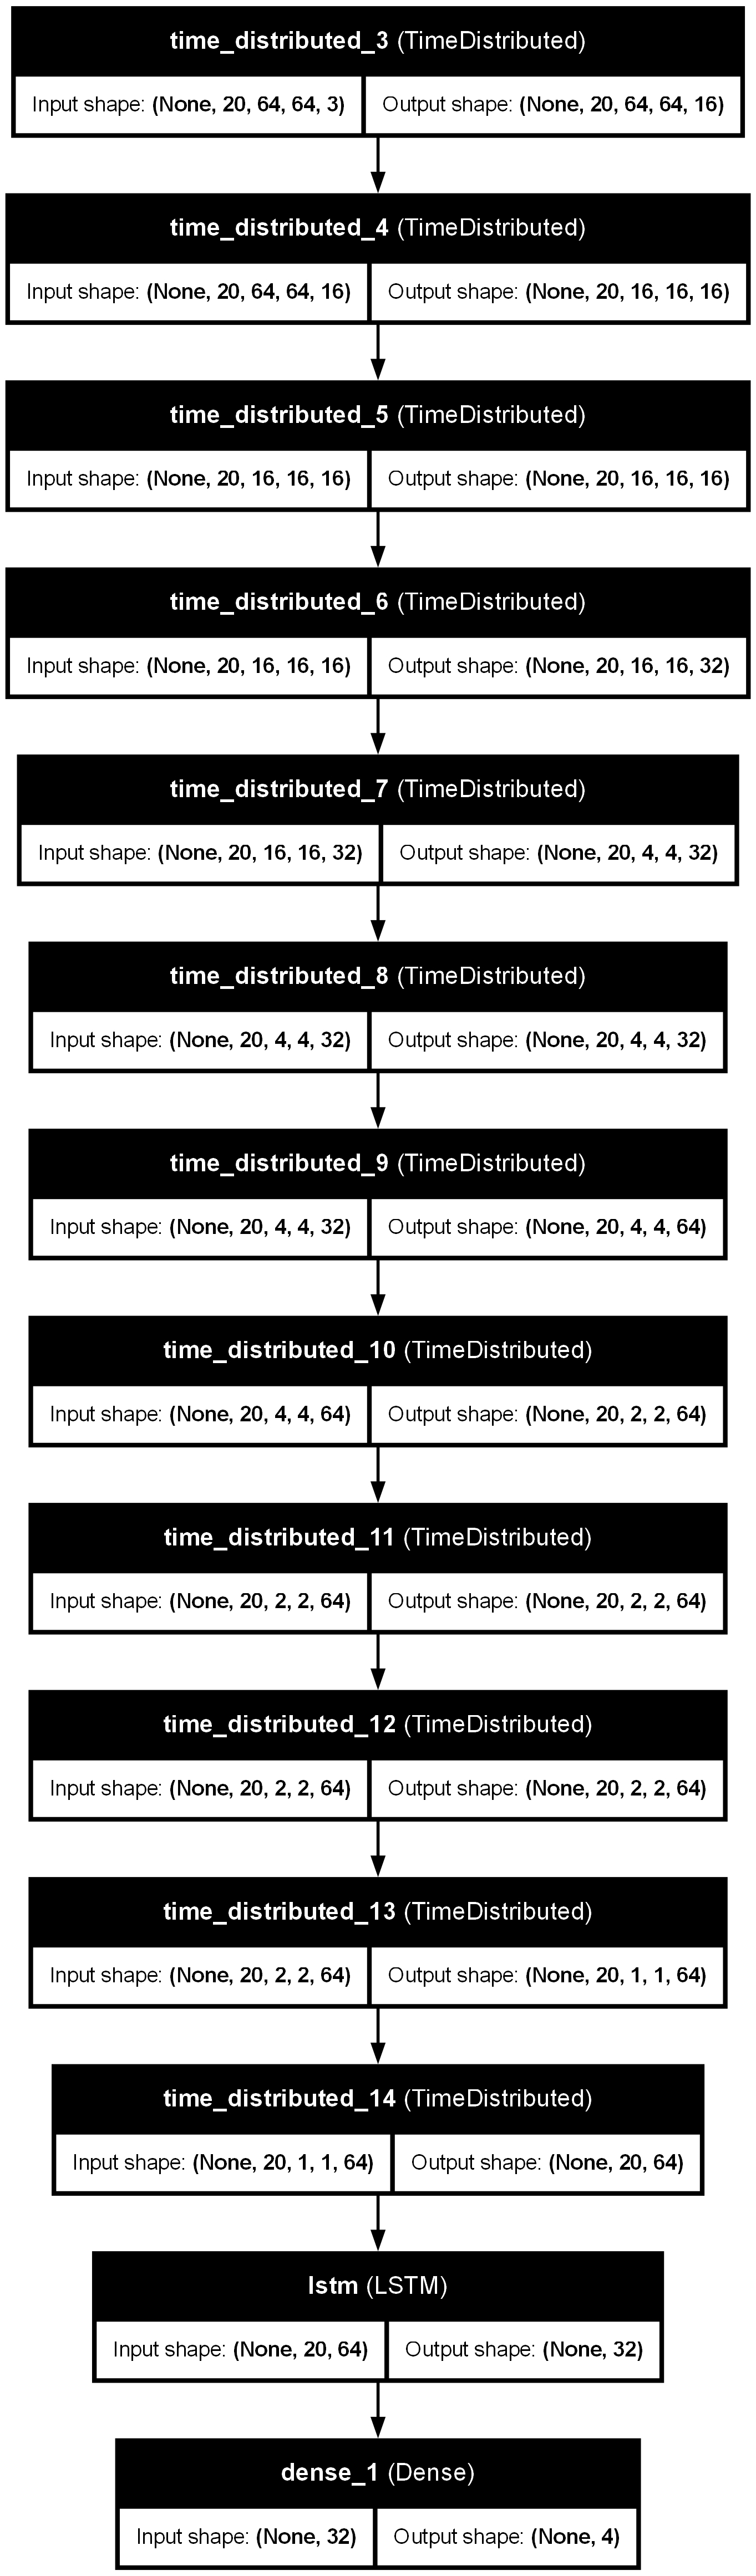

In [20]:
# Plot the structure of the contructed LRCN model.
keras.utils.plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### 5.2. Compile & Train the Model

After checking the structure, we will compile and start training the model.

In [21]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 15, mode = 'max', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics = ["accuracy"]
    )

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.1, callbacks = [early_stopping_callback])

Epoch 1/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.2726 - loss: 1.3981 - val_accuracy: 0.3333 - val_loss: 1.3688
Epoch 2/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.4198 - loss: 1.3227 - val_accuracy: 0.6154 - val_loss: 1.1289
Epoch 3/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.4973 - loss: 1.1253 - val_accuracy: 0.3590 - val_loss: 1.2388
Epoch 4/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.5744 - loss: 1.0189 - val_accuracy: 0.5128 - val_loss: 1.0949
Epoch 5/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.6801 - loss: 0.7943 - val_accuracy: 0.4359 - val_loss: 1.1824
Epoch 6/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.6914 - loss: 0.7491 - val_accuracy: 0.7179 - val_loss: 0.7479
Epoch 7/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.7797 - loss: 0.5934 - val_accuracy: 0.7692 - val_loss: 0.6769
Epoch 8/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.7913 - loss: 0.5048 - val_accu

#### Evaluating the trained Model
As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [22]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8636 - loss: 0.4371


### 5.3. Plot Model’s Loss & Accuracy Curves

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


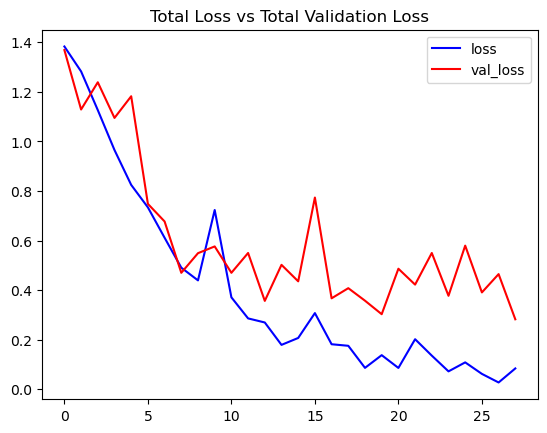

In [23]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

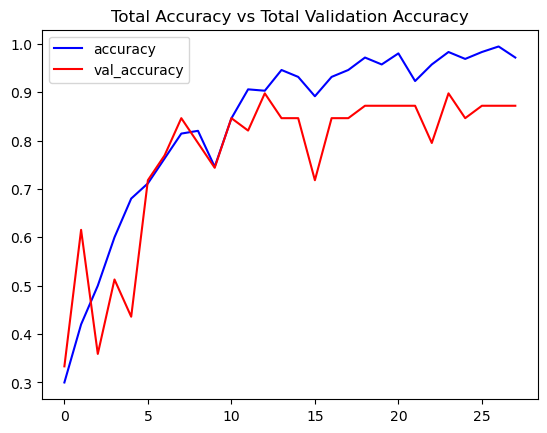

In [24]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## Step 6. Test the Best Performing Model on YouTube videos

From the results, it seems that the LRCN model performed significantly well for a small number of classes. so in this step, we will put the `LRCN` model to test on some youtube videos. 

### Create a Function to Download YouTube Videos

We will create a function **`download_youtube_videos()`** to download the YouTube videos first using **`pytube`** library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [25]:

def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''
     import os
     from pytube import YouTube # type: ignore
     yt = YouTube(youtube_video_url)
     video_stream = yt.streams.get_highest_resolution()
     output_video = yt.title.replace(" ", "_")
     output_video = "".join([c for c in output_video if c.isalnum() or c in "._- "])
     video_stream.download(output_path=output_directory, filename=f"{output_video}.mp4")
     video_path = os.path.join(output_directory, f"{output_video}.mp4")
     
     return video_path

### Download a Test Video

Now we will utilize the function **`download_youtube_videos()`** created above to download a youtube video on which the `LRCN` model will be tested.

In [26]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
url = 'https://www.youtube.com/watch?v=8u0qjmHIOcE'
video_file_path = download_youtube_videos(url, test_videos_directory)
print(f"Video downloaded to: {video_file_path}")


Video downloaded to: test_videos\Test_Video.mp4


### Create a Function To Perform Action Recognition on Videos

Next, we will create a function **`predict_on_video()`** that will simply read a video frame by frame from the path passed in as an argument and will perform action recognition on video and save the results.

In [ ]:

def predict_on_video(video_file_path, output_file_path,
                     SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH):

    video_reader = cv2.VideoCapture(video_file_path)

    if not video_reader.isOpened():
        raise RuntimeError("Cannot open video")

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fps = video_reader.get(cv2.CAP_PROP_FPS)
    if fps is None or fps <= 0:
        fps = 30

    video_writer = cv2.VideoWriter(
        output_file_path,
        cv2.VideoWriter_fourcc(*'XVID'),
        fps,
        (original_video_width, original_video_height)
    )

    if not video_writer.isOpened():
        raise RuntimeError("VideoWriter failed to open")

    # ==============================
    # AUTOMATIC SMOOTHING SETUP
    # ==============================
    SMOOTHING_SECONDS = 0.5
    smoothing_window = max(5, int(fps * SMOOTHING_SECONDS))

    prediction_queue = deque(maxlen=smoothing_window)
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    predicted_class_name = ""
    current_label = None
    label_hold_counter = 0
    TRANSITION_FRAMES = int(0.3 * fps)  # how long new label must persist
    CONFIDENCE_THRESHOLD = 0.5

    # ==============================
    # MAIN LOOP
    # ==============================
    while video_reader.isOpened():

        ok, frame = video_reader.read()
        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame.astype("float32") / 255.0
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:

            input_frames = np.expand_dims(np.array(frames_queue), axis=0)
            probs = LRCN_model.predict(input_frames, verbose=0)[0]

            # ---- Probability smoothing ----
            prediction_queue.append(probs)
            smoothed_probs = np.mean(prediction_queue, axis=0)

            new_label = np.argmax(smoothed_probs)
            confidence = smoothed_probs[new_label]

            # ---- Soft label transition ----
            if current_label is None:
                current_label = new_label

            elif new_label != current_label and confidence > CONFIDENCE_THRESHOLD:
                label_hold_counter += 1

                if label_hold_counter >= TRANSITION_FRAMES:
                    current_label = new_label
                    label_hold_counter = 0
            else:
                label_hold_counter = 0

            predicted_class_name = CLASSES_LIST[current_label]

        cv2.putText(
            frame,
            predicted_class_name,
            (10, 35),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2
        )

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()


### Perform Action Recognition on the Test Video

Now we will utilize the function **`predict_on_video()`** created above to perform action recognition on the test video we had downloaded using the function **`download_youtube_videos()`** and display the output video with the predicted action overlayed on it.

In [ ]:
# Construct the output video path.
from moviepy import VideoFileClip

video_title = os.path.basename(video_file_path)
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(video_file_path, output_video_file_path, SEQUENCE_LENGTH, IMAGE_HEIGHT=IMAGE_HEIGHT, IMAGE_WIDTH=IMAGE_WIDTH)


### Create a Function To Perform a Single Prediction on Videos


Now let's create a function that will perform a single prediction for the complete videos. We will extract evenly distributed **N** **`(SEQUENCE_LENGTH)`** frames from the entire video and pass them to the `LRCN` model. This approach is really useful when you are working with videos containing only one activity as it saves unnecessary computations and time in that scenario.  

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    if not video_reader.isOpened():
        raise RuntimeError("Cannot open video file")

    frames_list = []

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break

        # resize frame
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))

        # Ensure float32
        normalized_frame = resized_frame.astype("float32") / 255.0

        frames_list.append(normalized_frame)

    # Pad if video is too short
    while len(frames_list) < SEQUENCE_LENGTH:
        frames_list.append(frames_list[-1])

    # Convert to numpy array for model
    input_frames = np.expand_dims(np.array(frames_list), axis=0)
    predicted_labels_probabilities = LRCN_model.predict(input_frames, verbose=0)[0]

    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f"Action Predicted: {predicted_class_name}")
    print(f"Confidence: {predicted_labels_probabilities[predicted_label]:.2f}")

    video_reader.release()

    return {"Predicted action": predicted_class_name}


### Perform Single Prediction on a Test Video

Now we will utilize the function **`predict_single_action()`** created above to perform a single prediction on a complete youtube test video that we will download using the function **`download_youtube_videos()`**, we had created above.

In [63]:
# Download the youtube video.
video_file_path = download_youtube_videos('https://youtu.be/fc3w827kwyA', test_videos_directory)

# Perform Single Prediction on the Test Video.
predict_single_action(video_file_path, SEQUENCE_LENGTH)


Action Predicted: TaiChi
Confidence: 0.86


{'Predicted action': 'TaiChi'}

### Generating test video for multiple-actions clip

In [96]:
def combine_videos(video_paths, output_path):
    """
    Combine multiple video files into a single video.
    
    Args:
        video_paths: list of strings, paths to input video files
        output_path: string, path for combined output video
    """
    from moviepy import VideoFileClip, concatenate_videoclips
    
    clips = []

    for path in video_paths:
        clip = VideoFileClip(path)
        clips.append(clip)

    # Concatenate clips
    final_clip = concatenate_videoclips(clips, method="compose")  # "compose" ensures resolution is adjusted

    # Write the combined video
    final_clip.write_videofile(output_path, codec="libx264", audio_codec="aac")

    # Close clips to free memory
    for clip in clips:
        clip.close()
    final_clip.close()


In [97]:
def sample_videos_from_classes(class_directories, samples_per_class=1, seed=42):
    sampled_video_paths = []
    for class_dir in class_directories:
        video_files = os.listdir(class_dir)
        random.seed(seed)
        sampled_files = random.sample(video_files, min(samples_per_class, len(video_files)))
        for file in sampled_files:
            sampled_video_paths.append(os.path.join(class_dir, file))
    # shuffle the final list
    random.shuffle(sampled_video_paths)

    return sampled_video_paths

In [98]:
# get video class directories
VIDEO_CLASSES_DIRECTORIES = [os.path.join(DATASET_DIR, class_name) for class_name in CLASSES_LIST]

# sample videos from each class
sampled_files_paths = sample_videos_from_classes(VIDEO_CLASSES_DIRECTORIES, samples_per_class=3)
# print(sampled_files_paths)

combine_videos(
    video_paths=sampled_files_paths,
    output_path="combined_output_video.mp4"
)


['../data/UCF50\\Swing\\v_Swing_g12_c03.avi', '../data/UCF50\\WalkingWithDog\\v_WalkingWithDog_g03_c05.avi', '../data/UCF50\\Swing\\v_Swing_g02_c02.avi', '../data/UCF50\\Swing\\v_Swing_g05_c07.avi', '../data/UCF50\\HorseRace\\v_HorseRace_g04_c02.avi', '../data/UCF50\\WalkingWithDog\\v_WalkingWithDog_g17_c02.avi', '../data/UCF50\\TaiChi\\v_TaiChi_g01_c04.avi', '../data/UCF50\\WalkingWithDog\\v_WalkingWithDog_g01_c04.avi', '../data/UCF50\\HorseRace\\v_HorseRace_g17_c05.avi', '../data/UCF50\\TaiChi\\v_TaiChi_g21_c02.avi', '../data/UCF50\\TaiChi\\v_TaiChi_g04_c03.avi', '../data/UCF50\\HorseRace\\v_HorseRace_g01_c04.avi']
MoviePy - Building video combined_output_video.mp4.
MoviePy - Writing video combined_output_video.mp4



MoviePy - Done !
MoviePy - video ready combined_output_video.mp4


### For real-time webcam inference

In [ ]:
import cv2
import numpy as np
from collections import deque
import time

def real_time_webcam_inference(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH,
                               SMOOTHING_SECONDS=0.5, CONFIDENCE_THRESHOLD=0.6):
    """
    Real-time action recognition using webcam and LRCN model.

    Args:
    SEQUENCE_LENGTH: number of frames per sequence
    IMAGE_HEIGHT, IMAGE_WIDTH: model input size
    SMOOTHING_SECONDS: seconds of smoothing for predictions
    CONFIDENCE_THRESHOLD: minimum probability to switch label
    """

    # Initialize webcam
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise RuntimeError("Cannot open webcam")

    # Determine FPS of webcam
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0 or fps is None:
        fps = 30  # default

    # Smoothing window in frames
    smoothing_window = max(5, int(fps * SMOOTHING_SECONDS))

    # Buffers
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    prediction_queue = deque(maxlen=smoothing_window)

    # Soft label transition variables
    current_label = None
    label_hold_counter = 0
    TRANSITION_FRAMES = int(0.3 * fps)  # how long new label must persist

    predicted_class_name = ""

    print("[INFO] Starting webcam... Press 'q' to exit.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize & normalize
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame.astype("float32") / 255.0
        frames_queue.append(normalized_frame)

        # Only predict when we have enough frames
        if len(frames_queue) == SEQUENCE_LENGTH:
            input_frames = np.expand_dims(np.array(frames_queue), axis=0)
            probs = LRCN_model.predict(input_frames, verbose=0)[0]

            # Add to smoothing queue
            prediction_queue.append(probs)
            smoothed_probs = np.mean(prediction_queue, axis=0)

            new_label = np.argmax(smoothed_probs)
            confidence = smoothed_probs[new_label]

            # Soft label transition
            if current_label is None:
                current_label = new_label
            elif new_label != current_label and confidence > CONFIDENCE_THRESHOLD:
                label_hold_counter += 1
                if label_hold_counter >= TRANSITION_FRAMES:
                    current_label = new_label
                    label_hold_counter = 0
            else:
                label_hold_counter = 0

            predicted_class_name = CLASSES_LIST[current_label]

        # Overlay prediction on frame
        cv2.putText(frame, f"{predicted_class_name}", (10, 35),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Show webcam frame
        cv2.imshow("Real-Time Action Recognition", frame)

        # Exit on 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    

In [ ]:
real_time_webcam_inference(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH)